# **The Segmentation Mask Merger 5000**
#### Amil Khan | BisQue UCSB | Version 3.0
***

## Import Dependencies

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import os
from skimage import io
import h5py
import skimage
from skimage.io import imread
from skimage.transform import rotate
from skimage import data_dir
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

## Plot a Test Image

This helper function takes in one argument, `img_path`, which is simply the path of the image on your local computer. This step can be stepped if:
- You know what your data looks like
- Trust that everything in this notebook works
- Verified the absolute path of your image

**Arguments:**
- `img_path `: local path to volumetric image data, i.e. `.tif`

In [183]:
def image_visualizer5000(img_path, num_slice=0):
    img = skimage.io.imread(img_path, plugin='pil')
    print("Successfully Loaded. Image Shape:", img.shape)
    filename, file_extension = os.path.splitext(img_path)
    io.imshow(img[num_slice])
    plt.title("Slice Number: {} of {}".format(num_slice, len(img)), loc='left')
    plt.axis('off')

Successfully Loaded. Image Shape: (28, 512, 512)


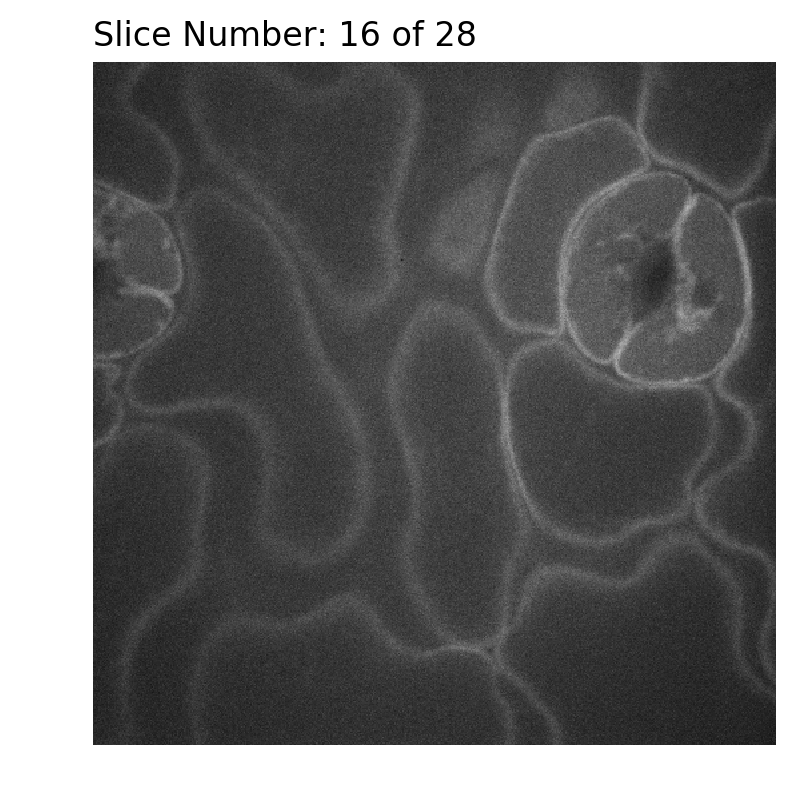

In [184]:
image_visualizer5000('/Users/macbook/Downloads/bisque-20190216.005014/T01.tif', num_slice=16)

## Segmentation Function

This function overlays a masked image over the original image
 takes two arguments, `NIFTI_img` and `volumetric_img`. 

**Arguments:**
- `NIFTI_img `: local path to NIFTI image, i.e. `.nii`
- `volumetric_img `: local path to volumetric image data, i.e. `.tif`

**Output:**
- Overlaid image. Basically, NIFTI image + Volumetric with slight darkening to non-segmented region

In [175]:
def segmentation(NIFTI_img, volumetric_img):
    
    filename, file_extension = os.path.splitext(NIFTI_img)
    if file_extension != '.nii': 
        print("Invalid Filetype  --> ",filename+file_extension,"\nPlease check the filepath and/or if you are importing a valid NIFTI image.")
        return None

    nii_img = nib.load(NIFTI_img)
    nii_img = nii_img.get_fdata()
    print("\n\n- Successfully Loaded {} Segmented Regions from NIFTI Image".format(len(np.unique(nii_img))))
    
    mask = skimage.io.imread(volumetric_img, plugin='pil')
    mask = np.swapaxes(mask, axis1=0, axis2=2)
    mask = (np.max(nii_img) - np.min(nii_img))*((mask - np.min(mask))/(np.max(mask) - np.min(mask)))+np.min(nii_img)
    
    print("- Successfully Loaded Mask", mask.shape)
    overlay = np.zeros_like(nii_img)
    
    for i in range(nii_img.shape[-1]):
        overlay[:,:,i] = np.where((nii_img[:,:,i] == np.min(nii_img)) , mask[:,:,i], nii_img[:,:,i])
        print('.', end=' ')
    print("\nSegmentation Merge Finished!\nOutput Shape:", np.rollaxis(overlay, axis=2).shape)
    return np.rollaxis(np.swapaxes(overlay, 0,1), axis=2) # So BisQue can read and view image correctly

In [176]:
tom = segmentation(NIFTI_img='/Users/macbook/Downloads/bisque-20190216.005040/all.nii', 
                   volumetric_img='/Users/macbook/Downloads/bisque-20190216.005014/T01.tif')



- Successfully Loaded 17 Segmented Regions from NIFTI Image
- Successfully Loaded Mask (512, 512, 28)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Segmentation Merge Finished!
Output Shape: (28, 512, 512)


## Verify the Output Image

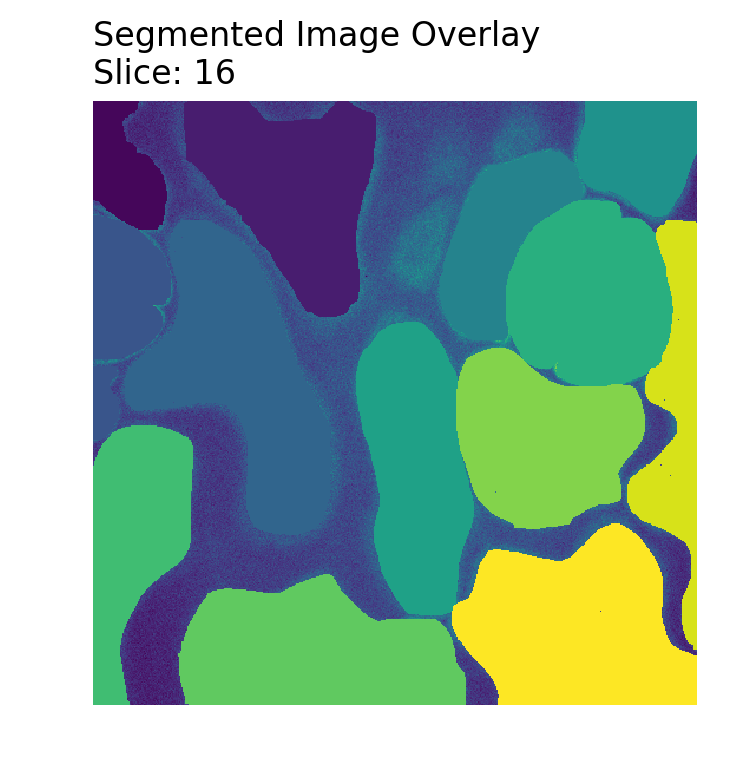

In [185]:
def overlay_visualizer(segmentation_output, num_slice=0):
    plt.imshow(segmentation_output[num_slice])
    plt.title('Segmented Image Overlay\nSlice: {}'.format(num_slice), loc='left')
    plt.axis('off')

overlay_visualizer(segmentation_output=tom, num_slice=16)

## Output to HDF file

If you are feeling ambitious, you can output the image to an HDF file and visualize it in 2D slices and a 3D volume using [BisQue](https://bisque.ece.ucsb.edu/client_service/). The output file will be created in your current working directory.

**Arguments:**
- `filename `: name of the output hdf file
- `key_name `: key/name of dataset in the HDF file
- `img`: Output image from segmentation function

In [177]:
def img_to_HDF(filename, key_name, img):
    f = h5py.File(filename, 'w')
    f.create_dataset(key_name, data=img)
    f.close()

In [178]:
img_to_HDF(filename='SuperTom.h5', key_name='Finished_Product', img=tom)

***